### degree -- home and work locations

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import shapely
from shapely.geometry import Point,Polygon,LineString

import json
import time
from copy import deepcopy

### data prep -- geo_edgelist saved in the end

In [11]:
# follower network -- data
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')

# read in data about individuals -- data2
userinfo = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "lat_work", "lon_work"]]

In [12]:
# edgelist with geoinfo
edgelist = pd.merge(pd.merge(edgelist, user_geo, left_on="user_id1", right_on="user_id", how="left"),\
               user_geo, left_on="user_id2", right_on="user_id", how="left", suffixes=("1", "2"))

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

In [13]:
# DISTANCE - home-home part

start_time = time.time()

# geometry cols
edgelist["geometry1"] = edgelist.apply(lambda r: Point(r["lon_home1"],r["lat_home1"]), axis=1)
edgelist["geometry2"] = edgelist.apply(lambda r: Point(r["lon_home2"],r["lat_home2"]), axis=1)

geo_edgelist = gpd.GeoDataFrame(edgelist)

# change crs
geo_edgelist = geo_edgelist.set_geometry('geometry2')
geo_edgelist.crs = {'init': 'epsg:4326'}
geo_edgelist = geo_edgelist.to_crs({'init': 'epsg:3857'})

geo_edgelist = geo_edgelist.set_geometry('geometry1')
geo_edgelist.crs = {'init': 'epsg:4326'}
geo_edgelist = geo_edgelist.to_crs({'init': 'epsg:3857'})

# set geometry
geo_edgelist = geo_edgelist.set_geometry('geometry1')

# home-home distance calculation
geo_edgelist['dist_hh'] = geo_edgelist['geometry1'].distance(geo_edgelist['geometry2'])

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


--- 390.20663619041443 seconds ---


In [5]:
# DISTANCE - work-work part

start_time = time.time()

# geometry cols
edgelist["geometry1"] = edgelist.apply(lambda r: Point(r["lon_work1"],r["lat_work1"]), axis=1)
edgelist["geometry2"] = edgelist.apply(lambda r: Point(r["lon_work2"],r["lat_work2"]), axis=1)

geo_edgelist2 = gpd.GeoDataFrame(edgelist)

# change crs
geo_edgelist2 = geo_edgelist2.set_geometry('geometry2')
geo_edgelist2.crs = {'init': 'epsg:4326'}
geo_edgelist2 = geo_edgelist2.to_crs({'init': 'epsg:3857'})

geo_edgelist2 = geo_edgelist2.set_geometry('geometry1')
geo_edgelist2.crs = {'init': 'epsg:4326'}
geo_edgelist2 = geo_edgelist2.to_crs({'init': 'epsg:3857'})

# set geometry
geo_edgelist2 = geo_edgelist2.set_geometry('geometry1')

# home-home distance calculation
geo_edgelist2['dist_ww'] = geo_edgelist2['geometry1'].distance(geo_edgelist2['geometry2'])

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


--- 428.23562598228455 seconds ---


In [18]:
# combine..
temp = geo_edgelist2.loc[:,["cbsacode", "user_id1", "user_id2", "dist_ww"]]
geo_edgelist = pd.merge(geo_edgelist, temp, on=["cbsacode", "user_id1", "user_id2"], how="left")

In [22]:
# at this point, save the data!!
export = geo_edgelist.drop(columns=['geometry1', 'geometry2'])
export.to_csv("../data/geo_edgelist_top50.csv.gz", compression="gzip", index=False)

### spatial distribution of ego networks

In [2]:
# data IN
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

In [3]:
# bin distances
binsize=500

geo_edgelist["dh_bin"] = binsize*(geo_edgelist["dist_hh"]/binsize).map(int)+500
geo_edgelist["dw_bin"] = binsize*(geo_edgelist["dist_ww"]/binsize).map(int)+500

In [4]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [5]:
# loop -- HOME
dh_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table = pd.merge(dh_table, temp, on="user_id", how="left")

In [6]:
# loop -- WORK
dw_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dw_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table = pd.merge(dw_table, temp, on="user_id", how="left")

In [7]:
# merge the resuls of the loops
d_table = pd.merge(dh_table, dw_table, on=["user_id", "degree"], how="left")

In [8]:
# remove users with less than 10 ties (!!!) AND replace NANs
d_table = d_table[d_table["degree"]>=10] 
d_table = d_table.fillna(0)

In [9]:
# get the share of each degree
for c in list(d_table.columns[2:,]):    
    d_table[str(c)+"_share"] = round((d_table[str(c)] / d_table["degree"]), 3)

In [10]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_table.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_table[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result = pd.DataFrame(frame)

In [11]:
# cumulative shares -- percent of ties by distance
result["degree_share_cum"] = result.groupby("type")["avg_degree_share"].cumsum()

<ipython-input-36-b6f498d067bf>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
<ipython-input-36-b6f498d067bf>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


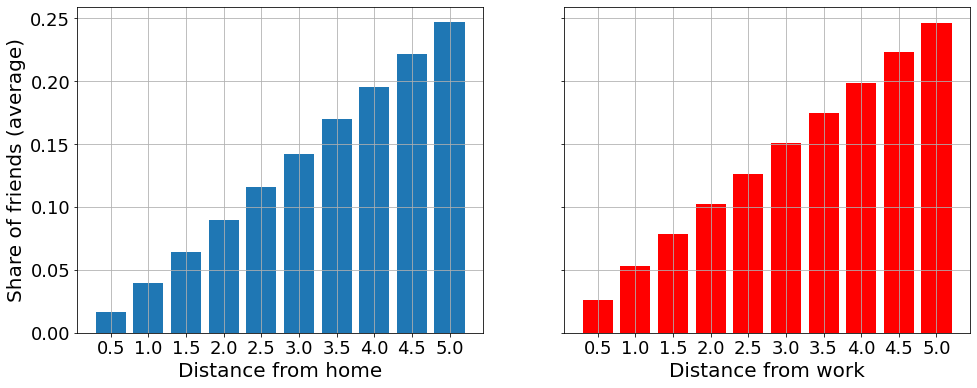

In [36]:
temp_home = result[result["type"]=="home"][:10]
temp_work = result[result["type"]=="work"][:10]

labels = list((np.linspace(0.5,5,10)))

plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,2,figsize=(16,6), sharey=True)

ax[0].bar(temp_home["dist"], temp_home["degree_share_cum"])
ax[0].grid()
ax[0].set_xticklabels(labels)
ax[0].set_xlabel("Distance from home", size=20)
# ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1)) 
ax[0].set_ylabel("Share of friends (average)", size=20)



ax[1].bar(temp_work["dist"], temp_work["degree_share_cum"], color="r")
ax[1].grid()
ax[1].set_xticklabels(labels)
ax[1].set_xlabel("Distance from work", size=20)

plt.show()

### futher issues
* home-work definitions + social netwoks (example)
* top50 metro areas average degree in 2km from H-W (similar to commuting)
* boxplot on this - or boxplot + distribution (second y is too complicated..)
* poor-rich users and their local degree

### income and ego network distribution

In [21]:
# tract info
censusdata = pd.read_csv("../data/censusdata_top50_2012.csv")

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

# geoid creation
censusdata['geoid'] = censusdata.apply(create_geoid,axis=1)

In [22]:
# userdata IN
userdata = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)

# remove bots
bot_flags = json.load(open("../data/bot_flags.json"))
userdata['drop'] = userdata['user_id'].map(int).map(str).map(bot_flags)
userdata = userdata[userdata['drop']==0]

In [23]:
## add cbsacodes to census tract level dataframe
temp = userdata.loc[:,['cbsacode', 'tract_home']].drop_duplicates()

# merge cbsacodes
census_df = pd.merge(censusdata, temp, left_on="geoid", right_on="tract_home", how="left")
census_df = census_df.drop(columns=("tract_home"))

# further filters
census_df = census_df[(census_df['income'] > 0)]

# remove NAs...
census_df = census_df.dropna()
census_df.shape

(38355, 23)

In [24]:
# get income percentiles by cbsacode
percentile = 25
census_df["income_lim1"] = census_df.cbsacode.map(census_df.groupby("cbsacode")['income']\
                                                  .quantile(percentile/100).to_dict())

census_df["income_lim2"] = census_df.cbsacode.map(census_df.groupby("cbsacode")['income']\
                                                  .quantile(1-percentile/100).to_dict())

In [25]:
# merging the user data and census data both on home and work census tracts
temp = pd.merge(userdata, census_df, left_on=["cbsacode", "tract_home"], right_on=["cbsacode", "geoid"], how="left")

# poor / rich dummies
po = (temp['income'] < temp["income_lim1"])
temp['poor'] = po.astype(int)

ri = (temp['income'] > temp["income_lim2"])
temp['rich'] = ri.astype(int)

# keep the necessary cols
temp = temp.loc[:,["user_id", "poor", "rich"]]

In [26]:
# data IN -- degree part
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

In [27]:
# bin distances
binsize=500

geo_edgelist["dh_bin"] = binsize*(geo_edgelist["dist_hh"]/binsize).map(int)+500
geo_edgelist["dw_bin"] = binsize*(geo_edgelist["dist_ww"]/binsize).map(int)+500

In [28]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [32]:
degree_tab = pd.merge(degree_tab, temp, on="user_id", how="inner")

In [56]:
# loop -- HOME
dh_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table = pd.merge(dh_table, temp, on="user_id", how="left")

In [57]:
# loop -- WORK
dw_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dw_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table = pd.merge(dw_table, temp, on="user_id", how="left")

In [58]:
# merge the resuls of the loops
dw_table = dw_table.drop(columns=["poor", "rich"])
d_table = pd.merge(dh_table, dw_table, on=["user_id", "degree"], how="left")

In [59]:
# remove users with less than 10 ties (!!!) AND replace NANs
d_table = d_table[d_table["degree"]>=10] 
d_table = d_table.fillna(0)
d_table.shape

(85077, 44)

In [60]:
# get the share of each degree
for c in list(d_table.columns[2:,]):    
    d_table[str(c)+"_share"] = round((d_table[str(c)] / d_table["degree"]), 3)

In [65]:
# poor users
d_poor = d_table[d_table["poor"]==1]

# rich users
d_rich = d_table[d_table["rich"]==1]

In [66]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_poor.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_poor[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result_poor = pd.DataFrame(frame)

In [68]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_rich.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_rich[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result_rich = pd.DataFrame(frame)

In [70]:
# cumulative shares -- percent of ties by distance
result_poor["degree_share_cum"] = result_poor.groupby("type")["avg_degree_share"].cumsum()
result_rich["degree_share_cum"] = result_rich.groupby("type")["avg_degree_share"].cumsum()

In [71]:
result_poor.head()

,dist,avg_degree_share,type,degree_share_cum
0,dh500_share,0.017972,home,0.017972
1,dh1000_share,0.026370,home,0.044342
2,dh1500_share,0.028594,home,0.072936
3,dh2000_share,0.029672,home,0.102608
4,dh2500_share,0.031345,home,0.133953


In [72]:
result_rich.head()

,dist,avg_degree_share,type,degree_share_cum
0,dh500_share,0.020078,home,0.020078
1,dh1000_share,0.024763,home,0.044841
2,dh1500_share,0.022672,home,0.067513
3,dh2000_share,0.021608,home,0.089121
4,dh2500_share,0.021823,home,0.110944


In [14]:
#load dataframe
table9 = pd.read_csv('../data/degree_inside_h3.csv', index_col = 0)

In [15]:
table9.head()

,user_id,deg0.5,deg1,deg1.5,deg2,deg2.5,deg3,deg3.5,deg4,deg4.5,...,deg5.5,deg6,deg6.5,deg7,deg7.5,deg8,deg8.5,deg9,deg9.5,deg10
0,4678,0,0,0,0,1,3,4,8,12,...,14,14,16,18,19,20,21,22,22,22
1,5212,0,1,5,15,19,27,29,30,38,...,49,52,55,61,73,81,88,93,98,99
2,794111,0,3,3,3,4,6,8,8,11,...,12,13,16,18,23,24,27,28,29,31
3,896221,0,0,2,2,3,5,6,6,9,...,10,14,15,15,16,16,18,19,19,20
4,963481,0,2,5,5,7,9,10,11,13,...,15,18,20,20,20,20,21,23,26,29


In [16]:
#Get change in number of friends in next 500 meters
table11 = deepcopy(table9)

table11['deg10'] =  table11['deg10'] - table11['deg9.5']
table11['deg9.5'] = table11['deg9.5'] - table11['deg9']
table11['deg9'] = table11['deg9'] - table11['deg8.5']
table11['deg8.5'] = table11['deg8.5'] - table11['deg8']
table11['deg8'] = table11['deg8'] - table11['deg7.5']
table11['deg7.5'] = table11['deg7.5'] - table11['deg7']
table11['deg7'] = table11['deg7'] - table11['deg6.5']
table11['deg6.5'] = table11['deg6.5'] - table11['deg6']
table11['deg6'] = table11['deg6'] - table11['deg5.5']
table11['deg5.5'] = table11['deg5.5'] - table11['deg5']
table11['deg5'] =  table11['deg5'] - table11['deg4.5']
table11['deg4.5'] = table11['deg4.5'] - table11['deg4']
table11['deg4'] = table11['deg4'] - table11['deg3.5']
table11['deg3.5'] = table11['deg3.5'] - table11['deg3']
table11['deg3'] = table11['deg3'] - table11['deg2.5']
table11['deg2.5'] = table11['deg2.5'] - table11['deg2']
table11['deg2'] = table11['deg2'] - table11['deg1.5']
table11['deg1.5'] = table11['deg1.5'] - table11['deg1']
table11['deg1'] = table11['deg1'] - table11['deg0.5']

In [17]:
#load dataframe
table11 = pd.read_csv('../data/degree_add_inside_h3.csv', index_col = 0)

In [18]:
#get degree ratio
table11b = pd.merge(table11, table7, 'left', on = 'user_id')

table11b['deg_r_0.5'] = table11b['deg0.5'] / table11b['degree_full']
table11b['deg_r_1'] = table11b['deg1'] / table11b['degree_full']
table11b['deg_r_1.5'] = table11b['deg1.5'] / table11b['degree_full']
table11b['deg_r_2'] = table11b['deg2'] / table11b['degree_full']
table11b['deg_r_2.5'] = table11b['deg2.5'] / table11b['degree_full']
table11b['deg_r_3'] = table11b['deg3'] / table11b['degree_full']
table11b['deg_r_3.5'] = table11b['deg3.5'] / table11b['degree_full']
table11b['deg_r_4'] = table11b['deg4'] / table11b['degree_full']
table11b['deg_r_4.5'] = table11b['deg4.5'] / table11b['degree_full']
table11b['deg_r_5'] = table11b['deg5'] / table11b['degree_full']
table11b['deg_r_5.5'] = table11b['deg5.5'] / table11b['degree_full']
table11b['deg_r_6'] = table11b['deg6'] / table11b['degree_full']
table11b['deg_r_6.5'] = table11b['deg6.5'] / table11b['degree_full']
table11b['deg_r_7'] = table11b['deg7'] / table11b['degree_full']
table11b['deg_r_7.5'] = table11b['deg7.5'] / table11b['degree_full']
table11b['deg_r_8'] = table11b['deg8'] / table11b['degree_full']
table11b['deg_r_8.5'] = table11b['deg8.5'] / table11b['degree_full']
table11b['deg_r_9'] = table11b['deg9'] / table11b['degree_full']
table11b['deg_r_9.5'] = table11b['deg9.5'] / table11b['degree_full']
table11b['deg_r_10'] = table11b['deg10'] / table11b['degree_full']

In [19]:
#get dataframe without user_id
table11c = table11b[['deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4','deg_r_4.5', 'deg_r_5','deg_r_5.5', 'deg_r_6','deg_r_6.5', 'deg_r_7','deg_r_7.5', 'deg_r_8','deg_r_8.5', 'deg_r_9','deg_r_9.5', 'deg_r_10']]

In [20]:
#save to dataframe
table11c = pd.read_csv('../data/deg_r_h3.csv', index_col = 0)

In [21]:
table11c.head()

,deg_r_0.5,deg_r_1,deg_r_1.5,deg_r_2,deg_r_2.5,deg_r_3,deg_r_3.5,deg_r_4,deg_r_4.5,deg_r_5,deg_r_5.5,deg_r_6,deg_r_6.5,deg_r_7,deg_r_7.5,deg_r_8,deg_r_8.5,deg_r_9,deg_r_9.5,deg_r_10
0,0.0,0.000000,0.000000,0.000000,0.020000,0.040000,0.020000,0.080000,0.080000,0.000000,0.040000,0.000000,0.040000,0.040000,0.020000,0.020000,0.020000,0.020000,0.000000,0.000000
1,0.0,0.006061,0.024242,0.060606,0.024242,0.048485,0.012121,0.006061,0.048485,0.030303,0.036364,0.018182,0.018182,0.036364,0.072727,0.048485,0.042424,0.030303,0.030303,0.006061
2,0.0,0.071429,0.000000,0.000000,0.023810,0.047619,0.047619,0.000000,0.071429,0.023810,0.000000,0.023810,0.071429,0.047619,0.119048,0.023810,0.071429,0.023810,0.023810,0.047619
3,0.0,0.000000,0.046512,0.000000,0.023256,0.046512,0.023256,0.000000,0.069767,0.023256,0.000000,0.093023,0.023256,0.000000,0.023256,0.000000,0.046512,0.023256,0.000000,0.023256
4,0.0,0.040816,0.061224,0.000000,0.040816,0.040816,0.020408,0.020408,0.040816,0.020408,0.020408,0.061224,0.040816,0.000000,0.000000,0.000000,0.020408,0.040816,0.061224,0.061224


In [22]:
#Get average value in each column and put it in a list
values = list(table11c.apply(lambda column: np.mean(column[:]), axis = 0))

In [23]:
#get degree ratio cumulatively
table11b2 = pd.merge(table9, table7, 'left', on = 'user_id')

table11b2['deg_r_0.5'] = table11b2['deg0.5'] / table11b2['degree_full']
table11b2['deg_r_1'] = table11b2['deg1'] / table11b2['degree_full']
table11b2['deg_r_1.5'] = table11b2['deg1.5'] / table11b2['degree_full']
table11b2['deg_r_2'] = table11b2['deg2'] / table11b2['degree_full']
table11b2['deg_r_2.5'] = table11b2['deg2.5'] / table11b2['degree_full']
table11b2['deg_r_3'] = table11b2['deg3'] / table11b2['degree_full']
table11b2['deg_r_3.5'] = table11b2['deg3.5'] / table11b2['degree_full']
table11b2['deg_r_4'] = table11b2['deg4'] / table11b2['degree_full']
table11b2['deg_r_4.5'] = table11b2['deg4.5'] / table11b2['degree_full']
table11b2['deg_r_5'] = table11b2['deg5'] / table11b2['degree_full']
table11b2['deg_r_5.5'] = table11b2['deg5.5'] / table11b2['degree_full']
table11b2['deg_r_6'] = table11b2['deg6'] / table11b2['degree_full']
table11b2['deg_r_6.5'] = table11b2['deg6.5'] / table11b2['degree_full']
table11b2['deg_r_7'] = table11b2['deg7'] / table11b2['degree_full']
table11b2['deg_r_7.5'] = table11b2['deg7.5'] / table11b2['degree_full']
table11b2['deg_r_8'] = table11b2['deg8'] / table11b2['degree_full']
table11b2['deg_r_8.5'] = table11b2['deg8.5'] / table11b2['degree_full']
table11b2['deg_r_9'] = table11b2['deg9'] / table11b2['degree_full']
table11b2['deg_r_9.5'] = table11b2['deg9.5'] / table11b2['degree_full']
table11b2['deg_r_10'] = table11b2['deg10'] / table11b2['degree_full']

table11b2b = table11b2[['deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4', 'deg_r_4.5', 'deg_r_5', 'deg_r_5.5','deg_r_6', 'deg_r_6.5','deg_r_7', 'deg_r_7.5','deg_r_8', 'deg_r_8.5','deg_r_9', 'deg_r_9.5','deg_r_10']]

valuesb = list(table11b2b.apply(lambda column: np.mean(column[:]), axis = 0))

valuesb

[0.02686312637088204,
 0.05612042428255415,
 0.08617216303371616,
 0.11700871114196477,
 0.145751640760416,
 0.1767538630368926,
 0.20837926156733957,
 0.23666339930507835,
 0.2664249438112825,
 0.29459606470253297,
 0.32049652064309536,
 0.3451468105756136,
 0.36991082757028626,
 0.3945845152649447,
 0.41713664993570027,
 0.43827574762583016,
 0.45777996699122847,
 0.4740283647635448,
 0.4906607310459037,
 0.5063505993225307]

### Work

In [24]:
#function to get egonetwork of ego with friends working inside dist meters
def workgo(ego,dist):
    m3h = m3.loc[m3['dist_from_friend_w'] < dist]
    m42c = m3h.loc[m3h['user_id1'] == ego]
    return m42c

In [83]:
# build dataframe of individuals' degrees inside 500 meters - 10 kms
listaproba2=[]

for user in tqdm_notebook(data['user_id1'].unique()):
    time.sleep(.01)
    r={}
    r['user_id'] = user
    for x in range(500, 10500, 500):
        r['deg' + str(x)] = len(workgo(user, x))
    listaproba2.append(r)   
tableproba2 = pd.DataFrame(listaproba2)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [87]:
#rename colums for shorter names
new_columns = tableproba2.columns.values  
new_columns[1:21] = ['deg0.5','deg1','deg1.5','deg2', 'deg2.5', 'deg3','deg3.5', 'deg4','deg4.5','deg5','deg5.5','deg6','deg6.5','deg7','deg7.5','deg8','deg8.5','deg9','deg9.5','deg10'] 
tableproba2.columns  = new_columns

In [89]:
#save dataframe
tableproba2.to_csv('../data/degree_inside_w3.csv')

In [25]:
#load dataframe
table9b = pd.read_csv('../data/degree_inside_w3.csv', index_col = 0)

In [26]:
table9b.head()

,user_id,deg0.5,deg1,deg1.5,deg2,deg2.5,deg3,deg3.5,deg4,deg4.5,...,deg5.5,deg6,deg6.5,deg7,deg7.5,deg8,deg8.5,deg9,deg9.5,deg10
0,4678,0,0,0,1,1,1,1,2,2,...,2,2,2,2,2,3,3,3,4,6
1,5212,2,4,14,20,24,32,48,59,69,...,86,91,98,99,102,105,113,115,118,122
2,794111,4,5,7,9,12,19,31,32,32,...,32,33,33,37,37,37,38,39,39,39
3,896221,0,0,0,0,0,1,2,2,4,...,11,14,17,20,22,24,28,29,29,30
4,963481,0,3,7,18,24,27,28,29,32,...,32,34,35,36,37,37,37,38,38,38


In [27]:
#Get change in number of friends in next 500 meters
table10 = deepcopy(table9b)

table10['deg10'] = table10['deg10'] - table10['deg9.5']
table10['deg9.5'] = table10['deg9.5'] - table10['deg9']
table10['deg9'] = table10['deg9'] - table10['deg8.5']
table10['deg8.5'] = table10['deg8.5'] - table10['deg8']
table10['deg8'] = table10['deg8'] - table10['deg7.5']
table10['deg7.5'] = table10['deg7.5'] - table10['deg7']
table10['deg7'] = table10['deg7'] - table10['deg6.5']
table10['deg6.5'] = table10['deg6.5'] - table10['deg6']
table10['deg6'] = table10['deg6'] - table10['deg5.5']
table10['deg5.5'] = table10['deg5.5'] - table10['deg5']
table10['deg5'] = table10['deg5'] - table10['deg4.5']
table10['deg4.5'] = table10['deg4.5'] - table10['deg4']
table10['deg4'] = table10['deg4'] - table10['deg3.5']
table10['deg3.5'] = table10['deg3.5'] - table10['deg3']
table10['deg3'] = table10['deg3'] - table10['deg2.5']
table10['deg2.5'] = table10['deg2.5'] - table10['deg2']
table10['deg2'] = table10['deg2'] - table10['deg1.5']
table10['deg1.5'] = table10['deg1.5'] - table10['deg1']
table10['deg1'] = table10['deg1'] - table10['deg0.5']

In [28]:
#load dataframe
table10 = pd.read_csv('../data/degree_add_inside_w3.csv', index_col = 0)

In [29]:
#Get degree ratios
table9c = pd.merge(table10, table7, 'left', on = 'user_id')

table9c['deg_r_0.5'] = table9c['deg0.5'] / table9c['degree_full']
table9c['deg_r_1'] = table9c['deg1'] / table9c['degree_full']
table9c['deg_r_1.5'] = table9c['deg1.5'] / table9c['degree_full']
table9c['deg_r_2'] = table9c['deg2'] / table9c['degree_full']
table9c['deg_r_2.5'] = table9c['deg2.5'] / table9c['degree_full']
table9c['deg_r_3'] = table9c['deg3'] / table9c['degree_full']
table9c['deg_r_3.5'] = table9c['deg3.5'] / table9c['degree_full']
table9c['deg_r_4'] = table9c['deg4'] / table9c['degree_full']
table9c['deg_r_4.5'] = table9c['deg4.5'] / table9c['degree_full']
table9c['deg_r_5'] = table9c['deg5'] / table9c['degree_full']
table9c['deg_r_5.5'] = table9c['deg5.5'] / table9c['degree_full']
table9c['deg_r_6'] = table9c['deg6'] / table9c['degree_full']
table9c['deg_r_6.5'] = table9c['deg6.5'] / table9c['degree_full']
table9c['deg_r_7'] = table9c['deg7'] / table9c['degree_full']
table9c['deg_r_7.5'] = table9c['deg7.5'] / table9c['degree_full']
table9c['deg_r_8'] = table9c['deg8'] / table9c['degree_full']
table9c['deg_r_8.5'] = table9c['deg8.5'] / table9c['degree_full']
table9c['deg_r_9'] = table9c['deg9'] / table9c['degree_full']
table9c['deg_r_9.5'] = table9c['deg9.5'] / table9c['degree_full']
table9c['deg_r_10'] = table9c['deg10'] / table9c['degree_full']


In [30]:
# create dataframe without user_id
table9d = table9c[['deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4', 'deg_r_4.5', 'deg_r_5', 'deg_r_5.5','deg_r_6', 'deg_r_6.5','deg_r_7', 'deg_r_7.5','deg_r_8', 'deg_r_8.5','deg_r_9', 'deg_r_9.5','deg_r_10']]

In [31]:
#load dataframe
table9d = pd.read_csv('../data/deg_r_w3.csv', index_col = 0)

In [32]:
#create list of average values in each column
values2 = list(table9d.apply(lambda column: np.mean(column[:]), axis = 0))

In [33]:
#cumulative degree ratio
table9b2 = pd.merge(table9b, table7, 'left', on = 'user_id')

table9b2['deg_r_0.5'] = table9b2['deg0.5'] / table9b2['degree_full']
table9b2['deg_r_1'] = table9b2['deg1'] / table9b2['degree_full']
table9b2['deg_r_1.5'] = table9b2['deg1.5'] / table9b2['degree_full']
table9b2['deg_r_2'] = table9b2['deg2'] / table9b2['degree_full']
table9b2['deg_r_2.5'] = table9b2['deg2.5'] / table9b2['degree_full']
table9b2['deg_r_3'] = table9b2['deg3'] / table9b2['degree_full']
table9b2['deg_r_3.5'] = table9b2['deg3.5'] / table9b2['degree_full']
table9b2['deg_r_4'] = table9b2['deg4'] / table9b2['degree_full']
table9b2['deg_r_4.5'] = table9b2['deg4.5'] / table9b2['degree_full']
table9b2['deg_r_5'] = table9b2['deg5'] / table9b2['degree_full']
table9b2['deg_r_5.5'] = table9b2['deg5.5'] / table9b2['degree_full']
table9b2['deg_r_6'] = table9b2['deg6'] / table9b2['degree_full']
table9b2['deg_r_6.5'] = table9b2['deg6.5'] / table9b2['degree_full']
table9b2['deg_r_7'] = table9b2['deg7'] / table9b2['degree_full']
table9b2['deg_r_7.5'] = table9b2['deg7.5'] / table9b2['degree_full']
table9b2['deg_r_8'] = table9b2['deg8'] / table9b2['degree_full']
table9b2['deg_r_8.5'] = table9b2['deg8.5'] / table9b2['degree_full']
table9b2['deg_r_9'] = table9b2['deg9'] / table9b2['degree_full']
table9b2['deg_r_9.5'] = table9b2['deg9.5'] / table9b2['degree_full']
table9b2['deg_r_10'] = table9b2['deg10'] / table9b2['degree_full']

table9b2b = table9b2[['deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4', 'deg_r_4.5', 'deg_r_5', 'deg_r_5.5','deg_r_6', 'deg_r_6.5','deg_r_7', 'deg_r_7.5','deg_r_8', 'deg_r_8.5','deg_r_9', 'deg_r_9.5','deg_r_10']]

values2b = list(table9b2b.apply(lambda column: np.mean(column[:]), axis = 0))

values2b

[0.04098882530475021,
 0.07689374202784034,
 0.10850007135794633,
 0.13699312480170922,
 0.161096201855696,
 0.1888702577880006,
 0.21361461179072105,
 0.23975429332704573,
 0.26488061326785833,
 0.2900502723757943,
 0.31536723347148915,
 0.33819966130060936,
 0.35993056643506155,
 0.38147156319993836,
 0.4011833421989836,
 0.42133391043388435,
 0.43912005341475674,
 0.4536952016024208,
 0.46901502365829933,
 0.4837580177412227]

### Create summary dataframe and plot

In [34]:
titles = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

In [35]:
#Degree ratio around home
frame = { 'distance (km)': titles , 'degree ratio': values, 'type': 'home'} 
  
result = pd.DataFrame(frame) 

In [36]:
#Degree ratio around work
frame2 = { 'distance (km)': titles , 'degree ratio': values2, 'type': 'work'} 
  
result2 = pd.DataFrame(frame2) 

In [37]:
result3 = pd.concat([result, result2])

In [38]:
sp.stats.mannwhitneyu(table11c['deg_r_0.5'], table9d['deg_r_0.5'])

MannwhitneyuResult(statistic=62761811.0, pvalue=8.992058508888681e-15)

In [39]:
sp.stats.mannwhitneyu(table11c['deg_r_1'], table9d['deg_r_1'])

MannwhitneyuResult(statistic=63966791.0, pvalue=0.0006354020174003667)

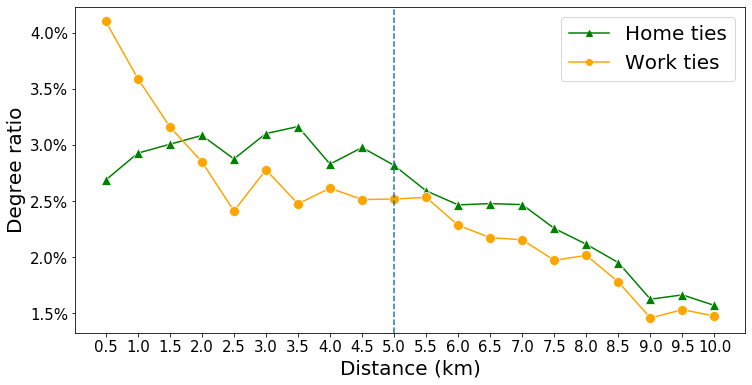

In [155]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(12, 6))

#color of lines
colorsList = [(0.0, 0.5019607843137255, 0.0),(1.0, 0.6470588235294118, 0.0)]

#lineplot created
ax = sns.lineplot(result3['distance (km)'], result3['degree ratio'], hue = result3['type'], style = result3['type'], palette = colorsList, dashes=False, ax = ax, markers=["^", "o"], markersize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Home ties', 'Work ties'], fontsize = 20)
ax.set(xlabel='Distance (km)', ylabel='Degree ratio')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.axvline(x=5.0,  linestyle='--')

#save chart
plt.savefig('../figures/gravitation32.jpg')

The chart shows that people in general make more of their ties in the direct neighborhood of their workplace compared to their home. Also, the decline of the ratio of ties is steeper in the distance from workplace case, it basically stagnates for a while in the distance from home case.

### Income at home - WORK ties

In [47]:
#Get dataframe with only user_id and degree ratios
table9db = table9c[['user_id', 'deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4', 'deg_r_4.5', 'deg_r_5', 'deg_r_5.5','deg_r_6', 'deg_r_6.5','deg_r_7', 'deg_r_7.5','deg_r_8', 'deg_r_8.5','deg_r_9', 'deg_r_9.5','deg_r_10']]

In [48]:
#Read in data about individuals merged with census data i.e. income and education group, ethnicity in home and work tract
tabmer2_all = pd.read_csv('../data/tabmer2_all.csv', index_col = 0)

In [49]:
tabmer2_all.head()

,user_id,degree_w,degree_h,deg_ratio_h,deg_ratio_w,degree_full,distance,geometry_h,geometry_w,income_h,...,asian_w,has_bach_h,has_bach_w,educ_group_h_3,educ_group_w_3,income_group_h_3,income_group_w_3,income_group_h_10,income_group_w_10,PR
0,4678,1,0,0.000000,0.020000,50,3.48,POINT (-71.126 42.42100000000001),POINT (-71.139 42.451),40840.0,...,123.0,0.195882,0.196721,in_between_educated,in_between_educated,in_between,rich,ig6,ig9,NaN
1,5212,20,15,0.090909,0.121212,165,3.22,POINT (-71.123 42.386),POINT (-71.093 42.368),71123.0,...,210.0,0.227968,0.189746,well_educated,in_between_educated,rich,poor,ig9,ig2,RP
2,794111,9,3,0.071429,0.214286,42,2.58,POINT (-71.077 42.346),POINT (-71.077 42.369),69840.0,...,523.0,0.166301,0.354798,in_between_educated,well_educated,rich,rich,ig9,ig9,RR
3,896221,0,2,0.046512,0.000000,43,0.00,POINT (-71.128 42.347),POINT (-71.128 42.347),62825.0,...,626.0,0.222095,0.222095,well_educated,well_educated,rich,rich,ig9,ig9,RR
4,963481,18,5,0.102041,0.367347,49,6.32,POINT (-71.123 42.4),POINT (-71.07600000000001 42.355),47743.0,...,305.0,0.282781,0.302183,well_educated,well_educated,rich,rich,ig7,ig9,RR


In [50]:
#merge degree ratios with census data
group = pd.merge(table9db, tabmer2_all[['user_id', 'income_group_h_3', 'income_group_w_3', 'income_group_h_10', 'income_group_w_10']], 'left', on = 'user_id')

In [51]:
#drop na values
group = group.dropna()

In [52]:
# get average degree ration for thos living in rich tracts
values3c = list(group.loc[group['income_group_h_3'] == 'rich'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [53]:
# get average degree ration for thos living in poor tracts
values4c = list(group.loc[group['income_group_h_3'] == 'poor'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [54]:
# get average degree ration for thos living in in_between tracts
values5c = list(group.loc[group['income_group_h_3'] == 'in_between'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [55]:
#put in dataframe
a3 = pd.DataFrame(values3c)
a3['income_group'] = 'rich'
a3['distance (km)'] = titles

In [56]:
b3 = pd.DataFrame(values4c)
b3['income_group'] = 'poor'
b3['distance (km)'] = titles

In [57]:
c3 = pd.DataFrame(values5c)
c3['income_group'] = 'in_between'
c3['distance (km)'] = titles

In [58]:
#concatenate dataframes into one
d3 = pd.concat([a3,b3,c3])
d3.columns = ['degree ratio', 'income_group', 'distance (km)']

Text(0.5, 1.0, 'Work ties by income group')

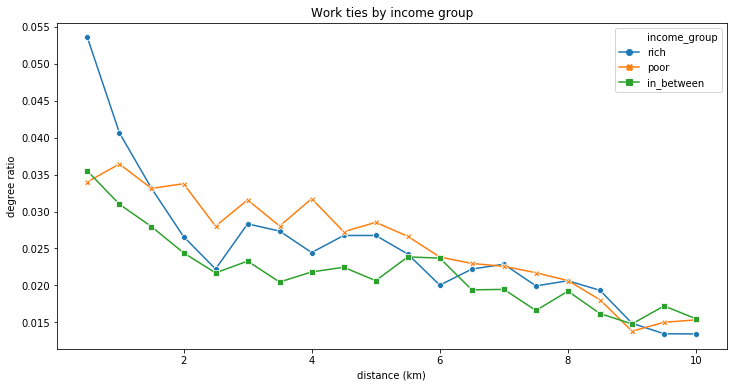

In [59]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'income_group', style = 'income_group', data= d3, dashes=False, ax = ax, markers = True).set_title("Work ties by income group")
#plt.savefig('../figures/gravitation_inc_w.jpg')

In [60]:
#fiter on only rich and poor
d32 = pd.concat([a3,b3])
d32.columns = ['degree ratio', 'income_group', 'distance (km)']

In [61]:
group_mw = group.loc[group['income_group_h_3'] == 'rich']

In [62]:
group_mw2 = group.loc[group['income_group_h_3'] == 'poor']

In [63]:
#calculate Mann-Whitnes test to see whether inside 0.5 km poor and rich degree ratios are really different from each other
sp.stats.mannwhitneyu(group_mw['deg_r_0.5'], group_mw2['deg_r_0.5'])

MannwhitneyuResult(statistic=5594891.5, pvalue=2.9862026551827905e-05)

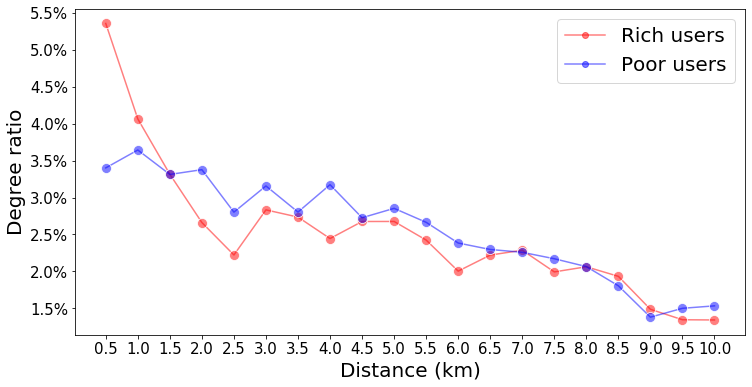

In [156]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(12, 6))

#colors of lines
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]

#lineplot created
sns.lineplot('distance (km)', 'degree ratio', hue = 'income_group', style = 'income_group',palette = colorsList, data= d32, dashes=False, ax = ax, markers=["o", "o"], markersize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['rich', 'poor'], fontsize = 20)
ax.set(xlabel='Distance (km)', ylabel='Degree ratio')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
leg = ax.get_legend()
leg.get_texts()[0].set_text('Rich users')
leg.get_texts()[1].set_text('Poor users')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))

#save chart
plt.savefig('../figures/gravitation_inc_w2.jpg')

By breaking down the ties around work by income groups, we can see that around work, the gravitatation rule is much stronger for rich people (lives in rich tract) than for poor people, they make more of their ties around their workplace and the share of their ties declines significantly as we go further from their workplace

Cumulative degree ratio

In [65]:
table9b2c = table9b2[['user_id','deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4', 'deg_r_4.5', 'deg_r_5', 'deg_r_5.5','deg_r_6', 'deg_r_6.5','deg_r_7', 'deg_r_7.5','deg_r_8', 'deg_r_8.5','deg_r_9', 'deg_r_9.5','deg_r_10']]

In [66]:
groupb = pd.merge(table9b2c, tabmer2_all[['user_id', 'income_group_h_3', 'income_group_w_3', 'income_group_h_10', 'income_group_w_10']], 'left', on = 'user_id')

In [67]:
groupb = groupb.dropna()

In [68]:
valuesb3c = list(groupb.loc[groupb['income_group_h_3'] == 'rich'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [70]:
valuesb4c = list(groupb.loc[groupb['income_group_h_3'] == 'poor'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))
valuesb4c

[0.03400889537169638,
 0.07044045520782236,
 0.10356312318213755,
 0.13733198486411366,
 0.16535244720342607,
 0.1969176991525135,
 0.2249482441810057,
 0.2566847832639818,
 0.2839458841428967,
 0.3124792185369792,
 0.33912235535655444,
 0.36296267001771965,
 0.38592708141035553,
 0.4085111621269842,
 0.43022307894159256,
 0.4508721310151584,
 0.46892267310175895,
 0.482723901625816,
 0.49772762659399306,
 0.5130607796955224]

### Ratio of people with bachelor at home - WORK ties

In [71]:
group4 = pd.merge(table9db, tabmer2_all[['user_id', 'educ_group_h_3', 'educ_group_w_3']], 'left', on = 'user_id')

In [72]:
group4 = group4.dropna()

In [73]:
values3f = list(group4.loc[group4['educ_group_h_3'] == 'well_educated'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [74]:
values4f = list(group4.loc[group4['educ_group_h_3'] == 'poorly_educated'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [75]:
values5f = list(group4.loc[group4['educ_group_h_3'] == 'in_between_educated'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [76]:
a6 = pd.DataFrame(values3f)
a6['educ_group_h_3'] = 'well_educated'
a6['distance (km)'] = titles

In [77]:
b6 = pd.DataFrame(values4f)
b6['educ_group_h_3'] = 'poorly_educated'
b6['distance (km)'] = titles

In [78]:
c6 = pd.DataFrame(values5f)
c6['educ_group_h_3'] = 'in_between_educated'
c6['distance (km)'] = titles

In [79]:
d6 = pd.concat([a6, b6, c6])
d6.columns = ['degree ratio', 'educated_group', 'distance (km)']

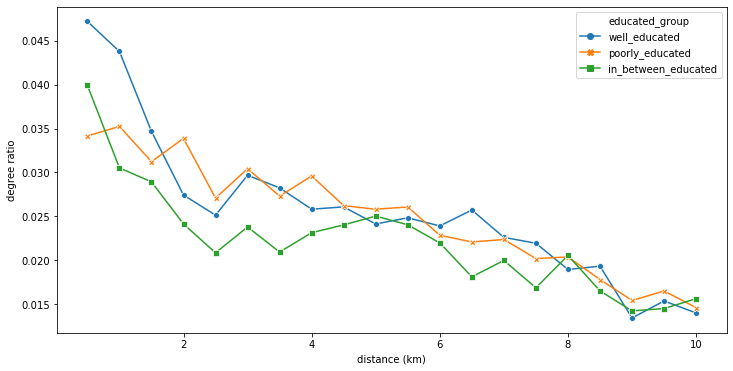

In [80]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'educated_group', style = 'educated_group', data= d6, dashes=False, ax = ax, markers=True)
#plt.savefig('../figures/gravitation_educ_h.jpg')

In [81]:
d62 = pd.concat([a6, b6])
d62.columns = ['degree ratio', 'educated_group', 'distance (km)']

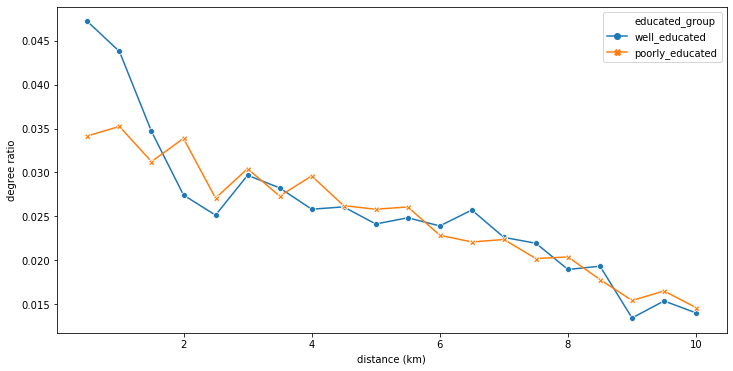

In [82]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'educated_group', style = 'educated_group', data= d62, dashes=False, ax = ax, markers=True)
#plt.savefig('../figures/gravitation_educ_h2.jpg')

If we break down the ties around work by educated groups, we can see that those living in well educated neighborhoods (defined as the ratio of the bachelor degree holders to the population of the tract being above the 70th percentile), make more friends close to their workplace, though the effect seems to be a bit smaller than it was for the income case.

### PR people - WORK ties

In [83]:
group6 = pd.merge(table9db, tabmer2_all[['user_id', 'PR']], 'left', on = 'user_id')

In [84]:
group6 = group6.dropna()

In [85]:
values3h = list(group6.loc[group6['PR'] == 'PR'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [86]:
values4h = list(group6.loc[group6['PR'] == 'PP'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [87]:
values5h = list(group6.loc[group6['PR'] == 'RP'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [88]:
values6h = list(group6.loc[group6['PR'] == 'RR'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [89]:
a8 = pd.DataFrame(values3h)
a8['PR'] = 'PR'
a8['distance (km)'] = titles

In [90]:
b8 = pd.DataFrame(values4h)
b8['PR'] = 'PP'
b8['distance (km)'] = titles

In [91]:
c8 = pd.DataFrame(values5h)
c8['PR'] = 'RP'
c8['distance (km)'] = titles

In [92]:
e8 = pd.DataFrame(values6h)
e8['PR'] = 'RR'
e8['distance (km)'] = titles

In [93]:
d8 = pd.concat([a8, b8, c8, e8])
d8.columns = ['degree ratio', 'commute_type', 'distance (km)']

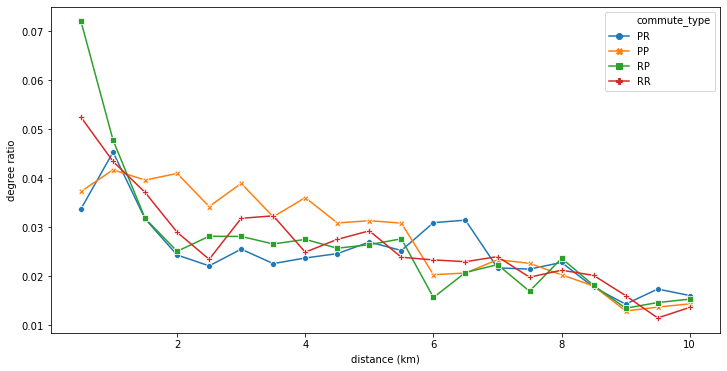

In [94]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'commute_type', style = 'commute_type', data= d8, dashes=False, ax = ax, markers=True)
#plt.savefig('../figures/PR_plot_w.jpg')

If we break down the ties around work by commute type (e.g. PR = from poor tract to rich), we can see that those people who live in rich tract, but commute to poor make the most of their ties around their workplace and the gravitation rule is strong in their case, while those who both live and work in rich tracts also make a significant ratio. For those living and working in poor tracts, the gravitation rule is very weak. For those commuting from a poor tract to a rich tract, the ratio of the ties directly around the workplace is the lowest, there is an upswing right afterwards however, but then the gravitation rule applies to them as well.

### Income at home - HOME ties

In [95]:
table11cb = table11b[['user_id', 'deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4', 'deg_r_4.5', 'deg_r_5', 'deg_r_5.5','deg_r_6', 'deg_r_6.5','deg_r_7', 'deg_r_7.5','deg_r_8', 'deg_r_8.5','deg_r_9', 'deg_r_9.5','deg_r_10']]

In [96]:
group2 = pd.merge(table11cb, tabmer2_all[['user_id', 'income_group_h_3', 'income_group_w_3']], 'left', on = 'user_id')

In [97]:
group2 = group2.dropna()

In [98]:
values3d = list(group2.loc[group2['income_group_h_3'] == 'rich'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [99]:
values4d = list(group2.loc[group2['income_group_h_3'] == 'poor'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [100]:
values5d = list(group2.loc[group2['income_group_h_3'] == 'in_between'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [101]:
a4 = pd.DataFrame(values3d)
a4['income_group'] = 'rich'
a4['distance (km)'] = titles

In [102]:
b4 = pd.DataFrame(values4d)
b4['income_group'] = 'poor'
b4['distance (km)'] = titles

In [103]:
c4 = pd.DataFrame(values5d)
c4['income_group'] = 'in_between'
c4['distance (km)'] = titles

In [104]:
d4 = pd.concat([a4,b4,c4])
d4.columns = ['degree ratio', 'income_group', 'distance (km)']

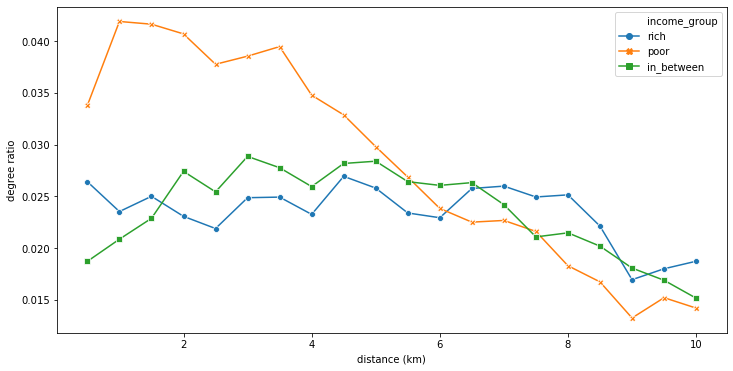

In [105]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'income_group', style = 'income_group', data = d4, dashes=False, ax = ax, markers=True)
#plt.savefig('../figures/gravitation_inc_h.jpg')

In [106]:
d42 = pd.concat([a4,b4])
d42.columns = ['degree ratio', 'income_group', 'distance (km)']

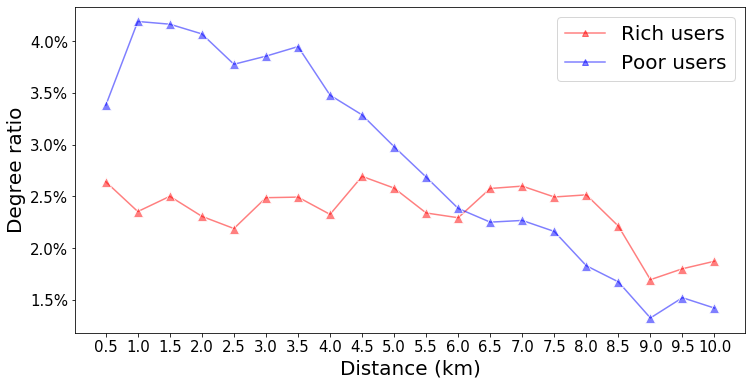

In [157]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(12, 6))

#set color
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]

#create lineplot
sns.lineplot('distance (km)', 'degree ratio', hue = 'income_group', style = 'income_group', palette = colorsList, data = d42, dashes=False, ax = ax, markers=["^", "^"], markersize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['rich', 'poor'], fontsize = 20)
ax.set(xlabel='Distance (km)', ylabel='Degree ratio')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
leg = ax.get_legend()
leg.get_texts()[0].set_text('Rich users')
leg.get_texts()[1].set_text('Poor users')

#save chart
plt.savefig('../figures/gravitation_inc_h2.jpg')

If we break down the ties arund home by income groups, we can see that those living in poor tracts develop much more of their ties close to their homes than the richer people, and the gravitation rule is stronger for them too. For richer people, the ratio of their ties is basically constant as we get further from their homes. It is also interesting that there is a little upswing at the beginning for poor people, which can be explained by the fact that those ties are made in the pastry shop, school etc. which are close to home, but are not made in the direct neighborhood, but a little bit farther.

Cumulative degree ratio

In [110]:
table11b2c = table11b2[['user_id','deg_r_0.5','deg_r_1', 'deg_r_1.5', 'deg_r_2', 'deg_r_2.5', 'deg_r_3', 'deg_r_3.5', 'deg_r_4', 'deg_r_4.5', 'deg_r_5', 'deg_r_5.5','deg_r_6', 'deg_r_6.5','deg_r_7', 'deg_r_7.5','deg_r_8', 'deg_r_8.5','deg_r_9', 'deg_r_9.5','deg_r_10']]

In [111]:
groupc = pd.merge(table11b2c, tabmer2_all[['user_id', 'income_group_h_3', 'income_group_w_3', 'income_group_h_10', 'income_group_w_10']], 'left', on = 'user_id')

In [112]:
groupc = groupc.dropna()

In [113]:
valuesc3c = list(groupc.loc[groupc['income_group_h_3'] == 'rich'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [114]:
valuesc4c = list(groupc.loc[groupc['income_group_h_3'] == 'poor'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [115]:
valuesc4c

[0.03379956282544048,
 0.07570363696875687,
 0.11734456803968615,
 0.15804581075843474,
 0.1958134501772532,
 0.23436466197836783,
 0.27383991287838916,
 0.30862348051782584,
 0.3414995010050726,
 0.37130641913715895,
 0.3981761014751608,
 0.4220145004622918,
 0.4445269995592464,
 0.4672044861196739,
 0.4888182131251786,
 0.5071175953259458,
 0.5238577172030833,
 0.5371108449591686,
 0.5523245770299375,
 0.5665326831310072]

### Ratio of people with bachelor degree - HOME ties

In [116]:
group3 = pd.merge(table11cb, tabmer2_all[['user_id', 'educ_group_h_3', 'educ_group_w_3']], 'left', on = 'user_id')

In [117]:
group3 = group3.dropna()

In [118]:
values3e = list(group3.loc[group3['educ_group_w_3'] == 'well_educated'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [119]:
values4e = list(group3.loc[group3['educ_group_w_3'] == 'poorly_educated'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [120]:
values5e = list(group3.loc[group3['educ_group_w_3'] == 'in_between_educated'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [121]:
a5 = pd.DataFrame(values3e)
a5['educ_group_w_3'] = 'well_educated'
a5['distance (km)'] = titles

In [122]:
b5 = pd.DataFrame(values4e)
b5['educ_group_w_3'] = 'poorly_educated'
b5['distance (km)'] = titles

In [123]:
c5 = pd.DataFrame(values5e)
c5['educ_group_w_3'] = 'in_between_educated'
c5['distance (km)'] = titles

In [124]:
d5 = pd.concat([a5, b5, c5])
d5.columns = ['degree ratio', 'educated_group', 'distance (km)']

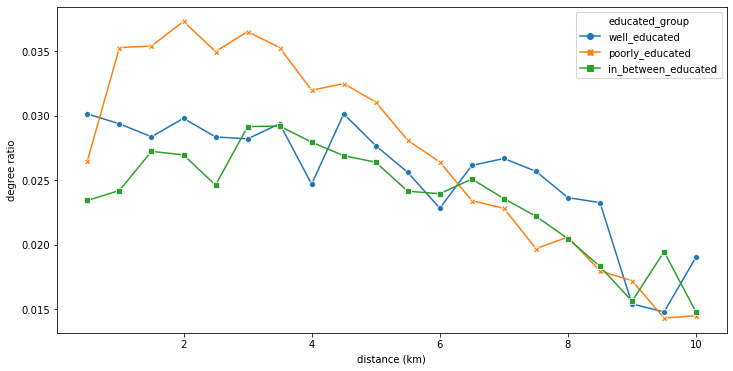

In [125]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'educated_group', style = 'educated_group', data= d5, dashes=False, ax = ax, markers=True)
#plt.savefig('../figures/gravitation_educ_w.jpg')

In [126]:
d52 = pd.concat([a5, b5])
d52.columns = ['degree ratio', 'educated_group', 'distance (km)']

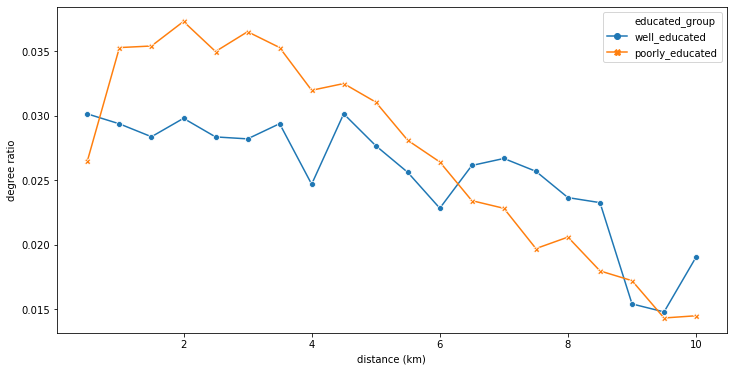

In [127]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'educated_group', style = 'educated_group', data= d52, dashes=False, ax = ax, markers=True)
#plt.savefig('../figures/gravitation_educ_w2.jpg')

If we break down the ties arund home by educated groups, we can see that those working in poorly educated neighborhoods, defined as the ratio of the bachelor degree holders to the population of the tract being below the 30th percentile make more friends close to their homes, though the effect seems to be smaller than it was in the income case.

### PR people - HOME ties

In [128]:
group5 = pd.merge(table11cb, tabmer2_all[['user_id', 'PR']], 'left', on = 'user_id')

In [129]:
group5 = group5.dropna()

In [130]:
values3g = list(group5.loc[group5['PR'] == 'PR'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [131]:
values4g = list(group5.loc[group5['PR'] == 'PP'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [132]:
values5g = list(group5.loc[group5['PR'] == 'RP'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [133]:
values6g = list(group5.loc[group5['PR'] == 'RR'].iloc[:,1:21].apply(lambda column: np.mean(column[:]), axis = 0))

In [134]:
a7 = pd.DataFrame(values3g)
a7['PR'] = 'PR'
a7['distance (km)'] = titles

In [135]:
b7 = pd.DataFrame(values4g)
b7['PR'] = 'PP'
b7['distance (km)'] = titles

In [136]:
c7 = pd.DataFrame(values5g)
c7['PR'] = 'RP'
c7['distance (km)'] = titles

In [137]:
e7 = pd.DataFrame(values6g)
e7['PR'] = 'RR'
e7['distance (km)'] = titles

In [138]:
d7 = pd.concat([a7, b7, c7, e7])
d7.columns = ['degree ratio', 'commute_type', 'distance (km)']

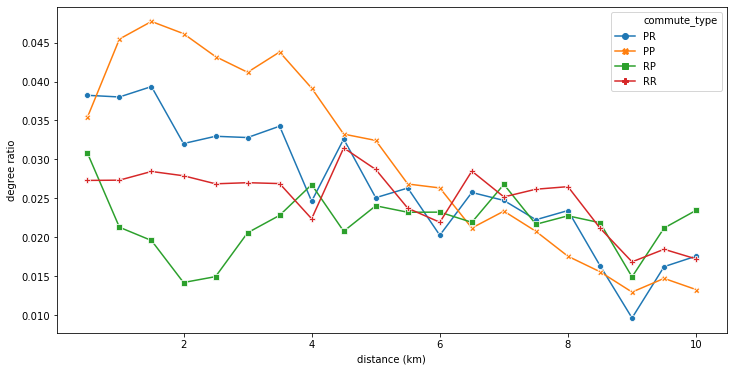

In [139]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.lineplot('distance (km)', 'degree ratio', hue = 'commute_type', style = 'commute_type', data= d7, dashes=False, ax = ax, markers=True)
#plt.savefig('../figures/PR_plot_h.jpg')

If we break down the ties around home by commute type (e.g. PR = from poor tract to rich), we can see that the highest ratio is for those living and working in poor tracts and the gravitation rule is pretty weak for them, also there is an upstring at the beginning. For those living in poor tract, but working in rich, they also make more of their ties around home, but the gravitation rule is stronger for them. For those living and working in rich tracts, the gravitation rule does not apply basically, they make as much of their ties close as far basically. For thise living in rich tracts, but working in poor, distance also does not seem to matter much, they make more of ther friends  in the direct neighborhood than a bit farther away.